In [5]:
# Cell 1: Import Libraries
# Purpose: Import all necessary libraries for the quantum anomaly detection project.
# ======================================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from qiskit import QuantumCircuit
from qiskit.primitives import Sampler
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_algorithms.optimizers import SPSA, ADAM, COBYLA
from qiskit.visualization import circuit_drawer  # For circuit visualization
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# Cell 2A: Load and Preprocess Training Dataset
# ======================================================

import pandas as pd
import numpy as np
import joblib
import logging
from sklearn.preprocessing import LabelEncoder

# Configure logger
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

def load_and_preprocess_data(
    file_path,
    scaler_path='scaler.pkl',
    pca_path='pca.pkl',
    n_components=None,
    log_transform=True,
    lower_percentile=1,
    upper_percentile=99,
    label_col='label',
    encoder_paths=None
):
    # 1. Load
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        logger.error(f"File not found: {file_path}")
        raise
    logger.info(f"Loaded {file_path} (shape={df.shape})")
    display(df.head(200000))

    # 2. Split features/labels
    if label_col in df:
        X = df.drop(label_col, axis=1)
        y = df[label_col].astype(int)
    else:
        X = df.copy()
        y = None

    # 3. Encode categoricals
    cat_cols = X.select_dtypes(include=['object']).columns.tolist()
    if cat_cols:
        if encoder_paths:
            # reuse saved encoders for consistency
            for col in cat_cols:
                le = joblib.load(encoder_paths[col])
                X[col] = le.transform(X[col])
        else:
            # train new encoders and save them
            for col in cat_cols:
                le = LabelEncoder().fit(X[col])
                X[col] = le.transform(X[col])
                joblib.dump(le, f'{col}_encoder.pkl')
        logger.info(f"Encoded columns: {cat_cols}")

    # 4. Log‐transform
    if log_transform:
        X = np.log1p(X)
        logger.info("Applied log1p transformation")

    # 5. Outlier capping
    low = np.percentile(X, lower_percentile, axis=0)
    high = np.percentile(X, upper_percentile, axis=0)
    X = np.clip(X, low, high)
    logger.info(f"Capped outliers at {lower_percentile}st/ {upper_percentile}th percentiles")

    # 6. Scale & PCA
    try:
        scaler = joblib.load(scaler_path)
        pca    = joblib.load(pca_path)
    except FileNotFoundError as e:
        logger.error(str(e))
        raise
    X_scaled  = scaler.transform(X)
    X_reduced = pca.transform(X_scaled)
    if n_components is not None:
        assert X_reduced.shape[1] == n_components, \
            f"PCA output ({X_reduced.shape[1]}) != expected ({n_components})"

    logger.info("Preprocessing complete.")
    return X_reduced, y

# -- Execute the loader for your training set --

X_train, y_train = load_and_preprocess_data(
    file_path='Training and Testing Sets/UNSW_NB15_training-set.csv',
    scaler_path='scaler.pkl',
    pca_path='pca.pkl',
    n_components=4,
    log_transform=True,
    lower_percentile=1,
    upper_percentile=99,
    label_col='label'
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

INFO:__main__:Loaded Training and Testing Sets/UNSW_NB15_training-set.csv (shape=(175341, 45))


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,13,24,0,0,0,24,24,0,Generic,1
175337,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,...,1,2,0,0,0,1,1,0,Shellcode,1
175338,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,13,0,0,0,3,12,0,Generic,1
175339,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,14,30,0,0,0,30,30,0,Generic,1


INFO:__main__:Encoded columns: ['proto', 'service', 'state', 'attack_cat']
INFO:__main__:Applied log1p transformation
INFO:__main__:Capped outliers at 1st/ 99th percentiles
INFO:__main__:Preprocessing complete.


X_train shape: (175341, 4), y_train shape: (175341,)


In [ ]:
# Cell 2B: Load and Preprocess Testing Dataset
# ======================================================

import pandas as pd
import numpy as np
import joblib
import logging

# Configure logger (if not already configured)
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

# Assuming `load_and_preprocess_data` is defined in Cell 2B

# Load & preprocess the test set
X_test, y_test = load_and_preprocess_data(
    file_path='Training and Testing Sets/UNSW_NB15_testing-set.csv',
    scaler_path='scaler.pkl',
    pca_path='pca.pkl',
    n_components=4,
    log_transform=True,
    lower_percentile=1,
    upper_percentile=99,
    label_col='label'
)

print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

INFO:__main__:Loaded Training and Testing Sets/UNSW_NB15_testing-set.csv (shape=(82332, 45))


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,82328,0.000005,udp,-,INT,2,0,104,0,200000.005100,...,1,2,0,0,0,2,1,0,Normal,0
82328,82329,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,...,1,1,0,0,0,3,2,0,Normal,0
82329,82330,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0
82330,82331,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0


INFO:__main__:Encoded columns: ['proto', 'service', 'state', 'attack_cat']
INFO:__main__:Applied log1p transformation
INFO:__main__:Capped outliers at 1st/ 99th percentiles
INFO:__main__:Preprocessing complete.


X_test shape: (82332, 4), y_test shape: (82332,)


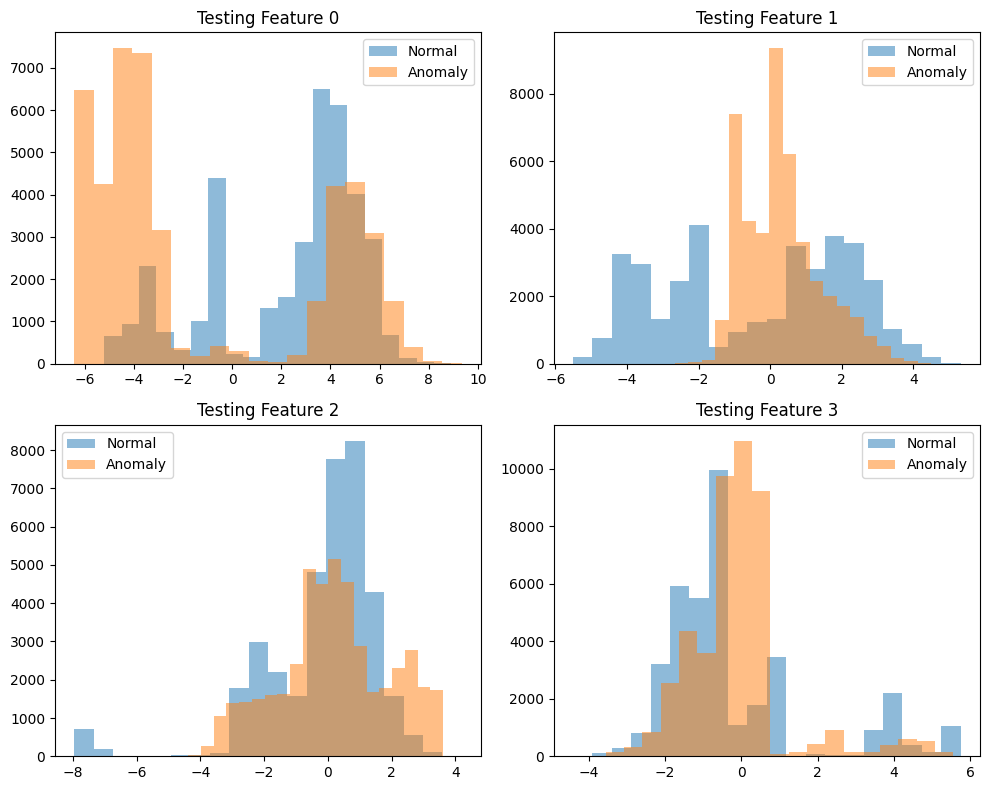

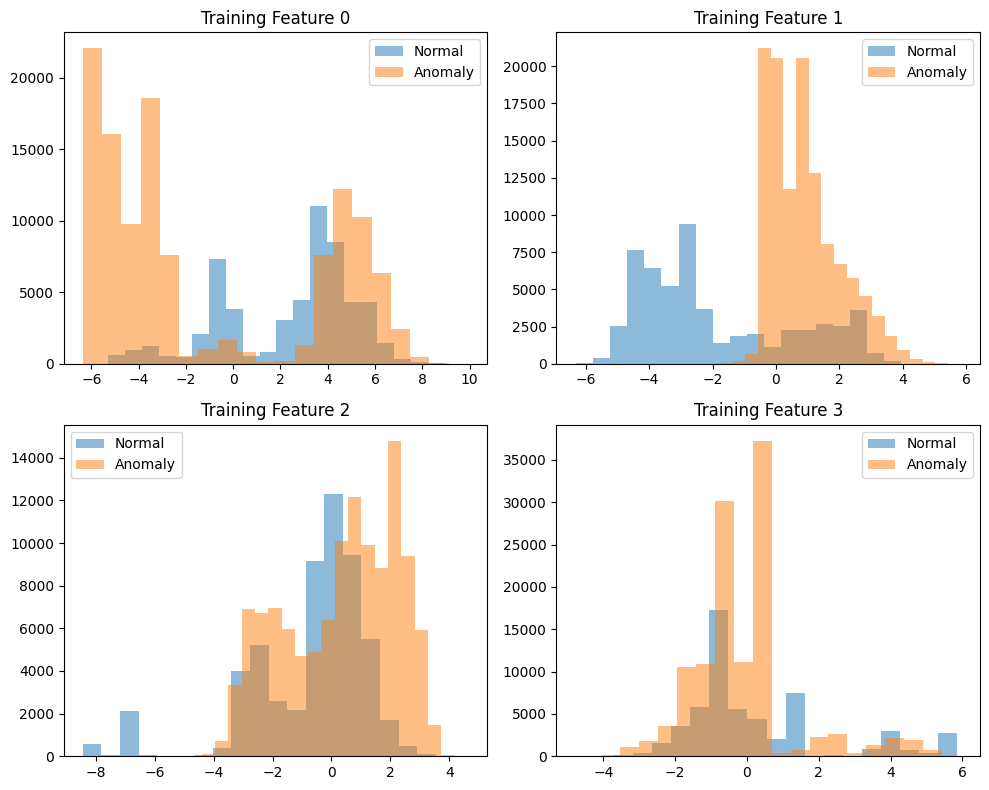

In [7]:
# Cell 3: Plot feature distributions (fixed)
import matplotlib.pyplot as plt
import numpy as np

def plot_train_feature_distributions(normal_data, anomaly_data, n_features=4):
    plt.figure(figsize=(10, 8))
    for i in range(n_features):
        plt.subplot(2, 2, i+1)
        plt.hist(normal_data[:, i], bins=20, alpha=0.5, label='Normal')
        plt.hist(anomaly_data[:, i], bins=20, alpha=0.5, label='Anomaly')
        plt.title(f"Training Feature {i}")
        plt.legend()
    plt.tight_layout()
    plt.savefig("figure_Training_Feature_Distributions.png", bbox_inches="tight")
    plt.show()

def plot_test_feature_distributions(test_data, test_labels, n_features=4, dataset_name="Testing"):
    normal_data = test_data[test_labels == 0]
    anomaly_data = test_data[test_labels == 1]

    plt.figure(figsize=(10, 8))
    for i in range(n_features):
        plt.subplot(2, 2, i+1)
        plt.hist(normal_data[:, i], bins=20, alpha=0.5, label='Normal')
        plt.hist(anomaly_data[:, i], bins=20, alpha=0.5, label='Anomaly')
        plt.title(f"{dataset_name} Feature {i}")
        plt.legend()
    plt.tight_layout()
    plt.savefig(f'figure_{dataset_name}_Feature_Distributions.png', bbox_inches='tight')
    plt.show()

# 1) Plot test distributions (you already had this)
plot_test_feature_distributions(X_test[:, :4], y_test, n_features=4, dataset_name="Testing")

# 2) Derive training subsets from X_train, y_train
normal_train = X_train[y_train == 0]
anomaly_train = X_train[y_train == 1]

# 3) Plot training distributions
plot_train_feature_distributions(normal_train[:, :4], anomaly_train[:, :4], n_features=4)

 Normal:  56000 samples — 31.94%
Anomaly: 119341 samples — 68.06%
=== Training Dataset Statistics ===


,mean,std,min,max,n_missing
PC1,8.299209e-17,4.486166,-6.358810,9.930748,0
PC2,1.426426e-17,2.103619,-6.318941,5.833761,0
PC3,-2.230412e-16,1.997528,-8.443966,4.633353,0
PC4,-9.595960e-17,1.636928,-4.771676,5.954541,0


=== Training Label Distribution ===
label
Anomaly    119341
Normal      56000
Name: count, dtype: int64

=== Testing Dataset Statistics ===


,mean,std,min,max,n_missing
PC1,0.361163,4.345998,-6.427752,9.341297,0
PC2,0.005826,1.917947,-5.504435,5.321195,0
PC3,0.051918,1.768588,-7.957136,4.202966,0
PC4,-0.164468,1.624880,-4.405446,5.748848,0


=== Testing Label Distribution ===
label
Anomaly    45332
Normal     37000
Name: count, dtype: int64


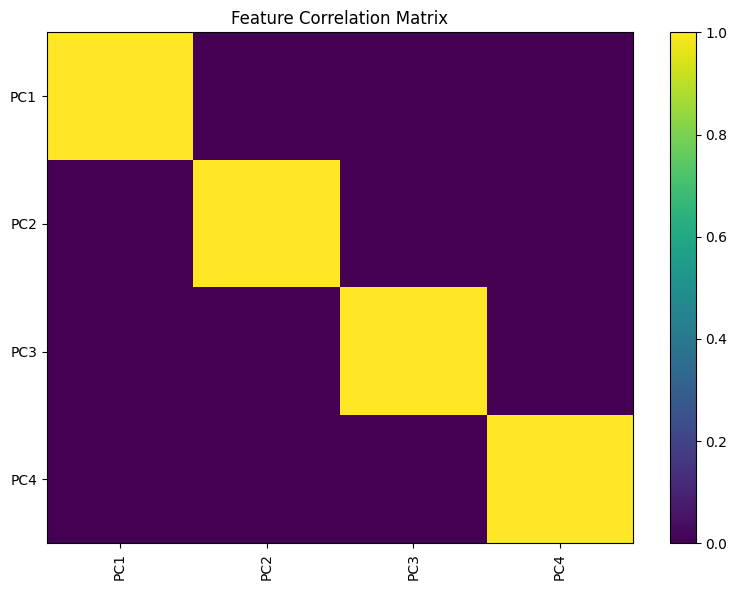

In [8]:
# Cell 4: Data Summary
# Purpose: Summarize both training and testing datasets programmatically.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 1. Define feature names based on your PCA components
n_components = X_train.shape[1]
feature_cols  = [f'PC{i+1}' for i in range(n_components)]

# 2. Training set summary
train_df    = pd.DataFrame(X_train, columns=feature_cols)
stats_train = train_df.describe().T[['mean', 'std', 'min', 'max']]
stats_train['n_missing'] = train_df.isnull().sum()
#---------------------------------------------------
labels, counts = np.unique(y_train, return_counts=True)
total = counts.sum()
for label, count in zip(labels, counts):
    pct = count / total * 100
    name = 'Normal' if label == 0 else 'Anomaly'
    print(f"{name:>7s}: {count:>6d} samples — {pct:5.2f}%")

print("=== Training Dataset Statistics ===")
display(stats_train)

dist_train = pd.Series(y_train).value_counts().rename(index={0: 'Normal', 1: 'Anomaly'})
print("=== Training Label Distribution ===")
print(dist_train)

# 3. Testing set summary
test_df    = pd.DataFrame(X_test, columns=feature_cols)
stats_test = test_df.describe().T[['mean', 'std', 'min', 'max']]
stats_test['n_missing'] = test_df.isnull().sum()

print("\n=== Testing Dataset Statistics ===")
display(stats_test)

dist_test = pd.Series(y_test).value_counts().rename(index={0: 'Normal', 1: 'Anomaly'})
print("=== Testing Label Distribution ===")
print(dist_test)

# 4. Optional: Feature correlation matrix for training set
plt.figure(figsize=(8, 6))
corr = train_df.corr()
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.title('Feature Correlation Matrix')
plt.xticks(np.arange(len(feature_cols)), feature_cols, rotation=90)
plt.yticks(np.arange(len(feature_cols)), feature_cols)
plt.tight_layout()
plt.show()

In [ ]:
# Cell 6: Train Q-VAE via ADAM, one fresh 200-sample mini-batch per epoch (no pickling lambdas)
import os, math, joblib, numpy as np
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_algorithms.optimizers import ADAM
from sklearn.metrics import log_loss

# ── HYPERPARAMETERS ────────────────────────────────────────────────────────────
NUM_EPOCHS      = 500        # number of epochs
NUM_QUBITS      = 4         # # of PCA components / qubits
NUM_LAYERS      = 8         # circuit depth
INIT_SCALE      = 0.03      # random init amplitude
LR              = 1e-3      # ADAM learning rate
BATCH_SIZE      = 200       # one mini-batch per epoch (100 normals + 100 anomalies)
VAL_FRAC        = 0.05      # 5% per class held‐out for validation
MIN_DELTA       = 0.01      # require this MA‐loss drop to checkpoint
CHECKPOINT_PATH = "qvae_adam_onebatch.joblib"
# ────────────────────────────────────────────────────────────────────────────────

def binary_interpret(bitstring):
    """Picklable interpret function: take first bit of the string."""
    b = format(bitstring, f"0{NUM_QUBITS}b")
    return int(b[0])

def make_circuit(n_qubits, n_layers):
    qc  = QuantumCircuit(n_qubits)
    inp = ParameterVector('x', n_qubits)
    wts = ParameterVector('θ', 2 * n_qubits * n_layers)
    # Data encoding
    for i in range(n_qubits):
        qc.ry(inp[i], i)
    # Variational layers
    idx = 0
    for _ in range(n_layers):
        for q in range(n_qubits):
            qc.rx(wts[idx], q); idx += 1
            qc.rz(wts[idx], q); idx += 1
        for q in range(n_qubits-1):
            qc.cx(q, q+1)
    return qc, inp, wts

# 1) Build circuit & QNN
qc, input_params, weight_params = make_circuit(NUM_QUBITS, NUM_LAYERS)
sampler = StatevectorSampler()
qnn     = SamplerQNN(
    sampler=sampler,
    circuit=qc,
    input_params=input_params,
    weight_params=weight_params,
    interpret=binary_interpret,
    output_shape=2
)

# 2) Initialize ADAM-based classifier (one analytic-grad step per .fit())
optimizer = ADAM(maxiter=1, lr=LR)
init_pt   = np.random.uniform(-INIT_SCALE, INIT_SCALE, size=len(weight_params))
clf       = NeuralNetworkClassifier(
    qnn,
    optimizer=optimizer,
    initial_point=init_pt,
    warm_start=True
)

# 3) Carve out validation pool (5%/class) and training pools
norm_idx = np.where(y_train == 0)[0]
anom_idx = np.where(y_train == 1)[0]
pn, pa   = np.random.permutation(norm_idx), np.random.permutation(anom_idx)

n_val_n = int(VAL_FRAC * len(pn))
n_val_a = int(VAL_FRAC * len(pa))
vn, tn  = pn[:n_val_n], pn[n_val_n:]
va, ta  = pa[:n_val_a], pa[n_val_a:]

# Assemble validation set
X_val = np.vstack((X_train[vn, :NUM_QUBITS],
                   X_train[va, :NUM_QUBITS]))
y_val = np.array([0]*len(vn) + [1]*len(va))

# Training pools (all remaining)
tn_pool = X_train[tn, :NUM_QUBITS]
ta_pool = X_train[ta, :NUM_QUBITS]

print(f"Validation set: {len(vn)} normals, {len(va)} anomalies")
print(f"Training pool:  {len(tn)} normals, {len(ta)} anomalies\n")

# 4) Training loop: ONE balanced mini-batch per epoch
half_b      = BATCH_SIZE // 2   # 100 normals + 100 anomalies
loss_history = []
best_ma      = float('inf')

for ep in range(1, NUM_EPOCHS+1):
    # draw one fresh mini-batch
    idx_n = np.random.choice(len(tn_pool), half_b, replace=False)
    idx_a = np.random.choice(len(ta_pool), half_b, replace=False)
    Xb    = np.vstack((tn_pool[idx_n], ta_pool[idx_a]))
    yb    = np.array([0]*half_b + [1]*half_b)

    clf.fit(Xb, yb)   # single ADAM step on 200 samples

    # validate & checkpoint
    probs = clf.predict_proba(X_val)[:,1]
    loss  = log_loss(y_val, np.clip(probs, 1e-10, 1-1e-10))
    loss_history.append(loss)
    ma = np.mean(loss_history[-5:])

    print(f"Epoch {ep:>2}/{NUM_EPOCHS} — val loss {loss:.4f}, 5-ep MA {ma:.4f}")
    if ma + MIN_DELTA < best_ma:
        best_ma = ma
        joblib.dump(clf, CHECKPOINT_PATH)
        print(f"  → saved checkpoint (MA = {best_ma:.4f})\n")

# 5) Reload best & attach history
clf = joblib.load(CHECKPOINT_PATH)
clf.loss_history = loss_history
print(f"\n✅ Done — best 5-ep MA-loss = {best_ma:.4f}")

Validation set: 2800 normals, 5967 anomalies
Training pool:  53200 normals, 113374 anomalies

Epoch  1/50 — val loss 1.8840, 5-ep MA 1.8840
  → saved checkpoint (MA = 1.8840)

Epoch  2/50 — val loss 1.8613, 5-ep MA 1.8727
  → saved checkpoint (MA = 1.8727)

Epoch  3/50 — val loss 1.8685, 5-ep MA 1.8713
Epoch  4/50 — val loss 1.8694, 5-ep MA 1.8708
Epoch  5/50 — val loss 1.8469, 5-ep MA 1.8660
Epoch  6/50 — val loss 1.8334, 5-ep MA 1.8559
  → saved checkpoint (MA = 1.8559)

Epoch  7/50 — val loss 1.8228, 5-ep MA 1.8482
Epoch  8/50 — val loss 1.8143, 5-ep MA 1.8374
  → saved checkpoint (MA = 1.8374)

Epoch  9/50 — val loss 1.8170, 5-ep MA 1.8269
  → saved checkpoint (MA = 1.8269)

Epoch 10/50 — val loss 1.8107, 5-ep MA 1.8196
Epoch 11/50 — val loss 1.8148, 5-ep MA 1.8159
  → saved checkpoint (MA = 1.8159)

Epoch 12/50 — val loss 1.7923, 5-ep MA 1.8098
Epoch 13/50 — val loss 1.7905, 5-ep MA 1.8051
  → saved checkpoint (MA = 1.8051)

Epoch 14/50 — val loss 1.7833, 5-ep MA 1.7983
Epoch 15/5

In [27]:
# Cell X: Save Q-VAE Loss History
import numpy as np

# Ensure your training has run and `loss_history` is in memory
if 'loss_history' not in globals():
    raise NameError(
        "loss_history not found. Please run your training cell first "
        "so that the list of per-epoch losses is defined."
    )

# Save as a NumPy array (.npy)
np.save("qvae_loss_history.npy", np.array(loss_history))
print(f"✅ Saved loss_history ({len(loss_history)} entries) to qvae_loss_history.npy")

# (Optional) also export to CSV for easy inspection:
import pandas as pd
pd.DataFrame({"val_loss": loss_history}).to_csv("qvae_loss_history.csv", index=False)
print("✅ Also saved loss_history to qvae_loss_history.csv")

✅ Saved loss_history (50 entries) to qvae_loss_history.npy
✅ Also saved loss_history to qvae_loss_history.csv


Visualizing a 4-qubit, 8-layer circuit with 68 parameters.


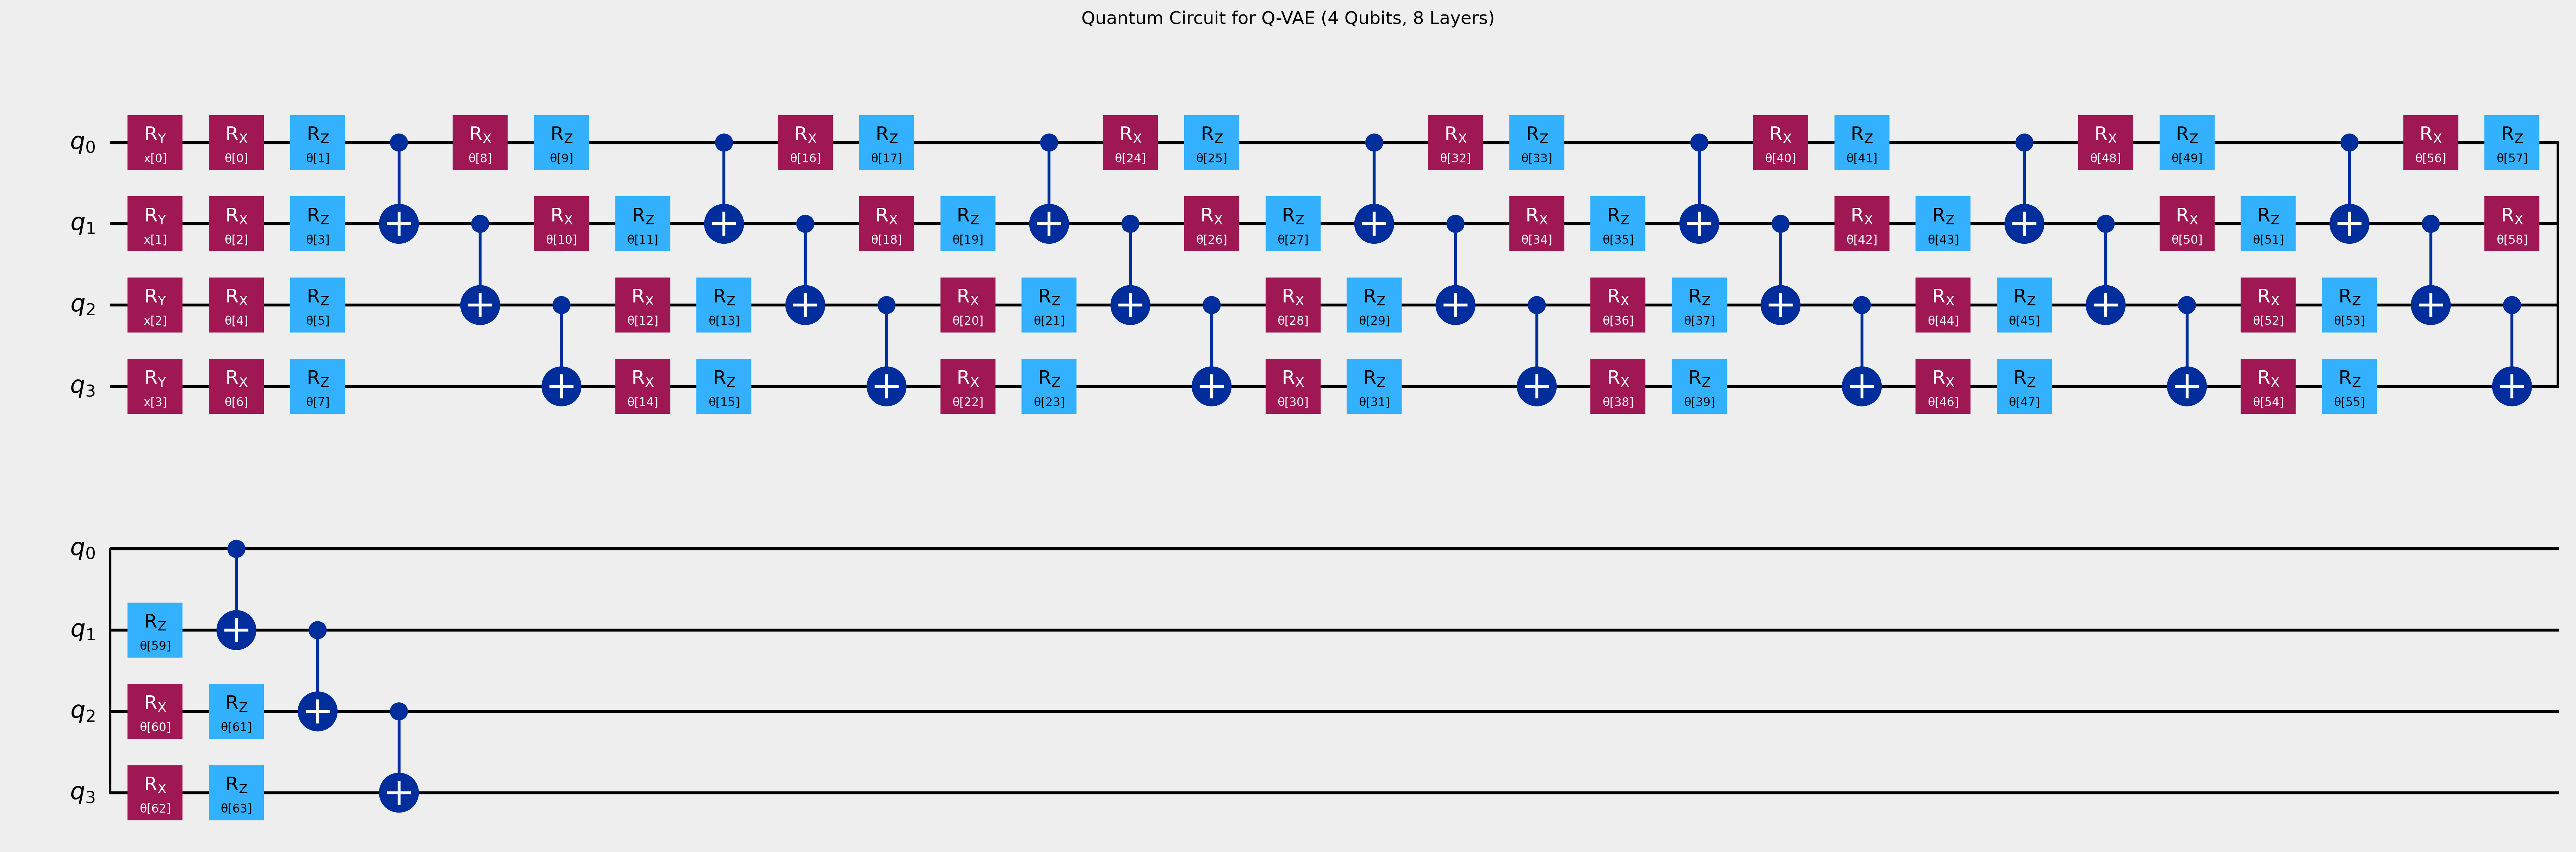

✅ Saved circuit figure to figure_2_Quantum_Circuit_for_Q-VAE.png


'figure_2_Quantum_Circuit_for_Q-VAE.png'

In [16]:
# Cell 6a: Visualize the trained variational circuit
# =================================================

import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib
matplotlib.use('Agg')   # for non-interactive backends

def visualize_trained_circuit(circuit, n_qubits, n_layers,
                              output_path='figure_2_Quantum_Circuit_for_Q-VAE.png'):
    print(f"Visualizing a {n_qubits}-qubit, {n_layers}-layer circuit with {len(circuit.parameters)} parameters.")
    fig = circuit.draw(output='mpl',
                       fold=30,
                       vertical_compression='high',
                       style={'backgroundcolor': '#EEEEEE'})
    fig.suptitle(f'Quantum Circuit for Q-VAE ({n_qubits} Qubits, {n_layers} Layers)', y=1.02)
    fig.tight_layout()
    fig.savefig(output_path, bbox_inches='tight', dpi=300)
    plt.close(fig)
    display(Image(filename=output_path))
    print(f"✅ Saved circuit figure to {output_path}")
    return output_path

# assuming you've already run the training cell:
visualize_trained_circuit(qc, NUM_QUBITS, NUM_LAYERS)

/var/folders/71/l0m_98fs0mg7z7032qxwwdg80000gn/T/ipykernel_72060/3226671900.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


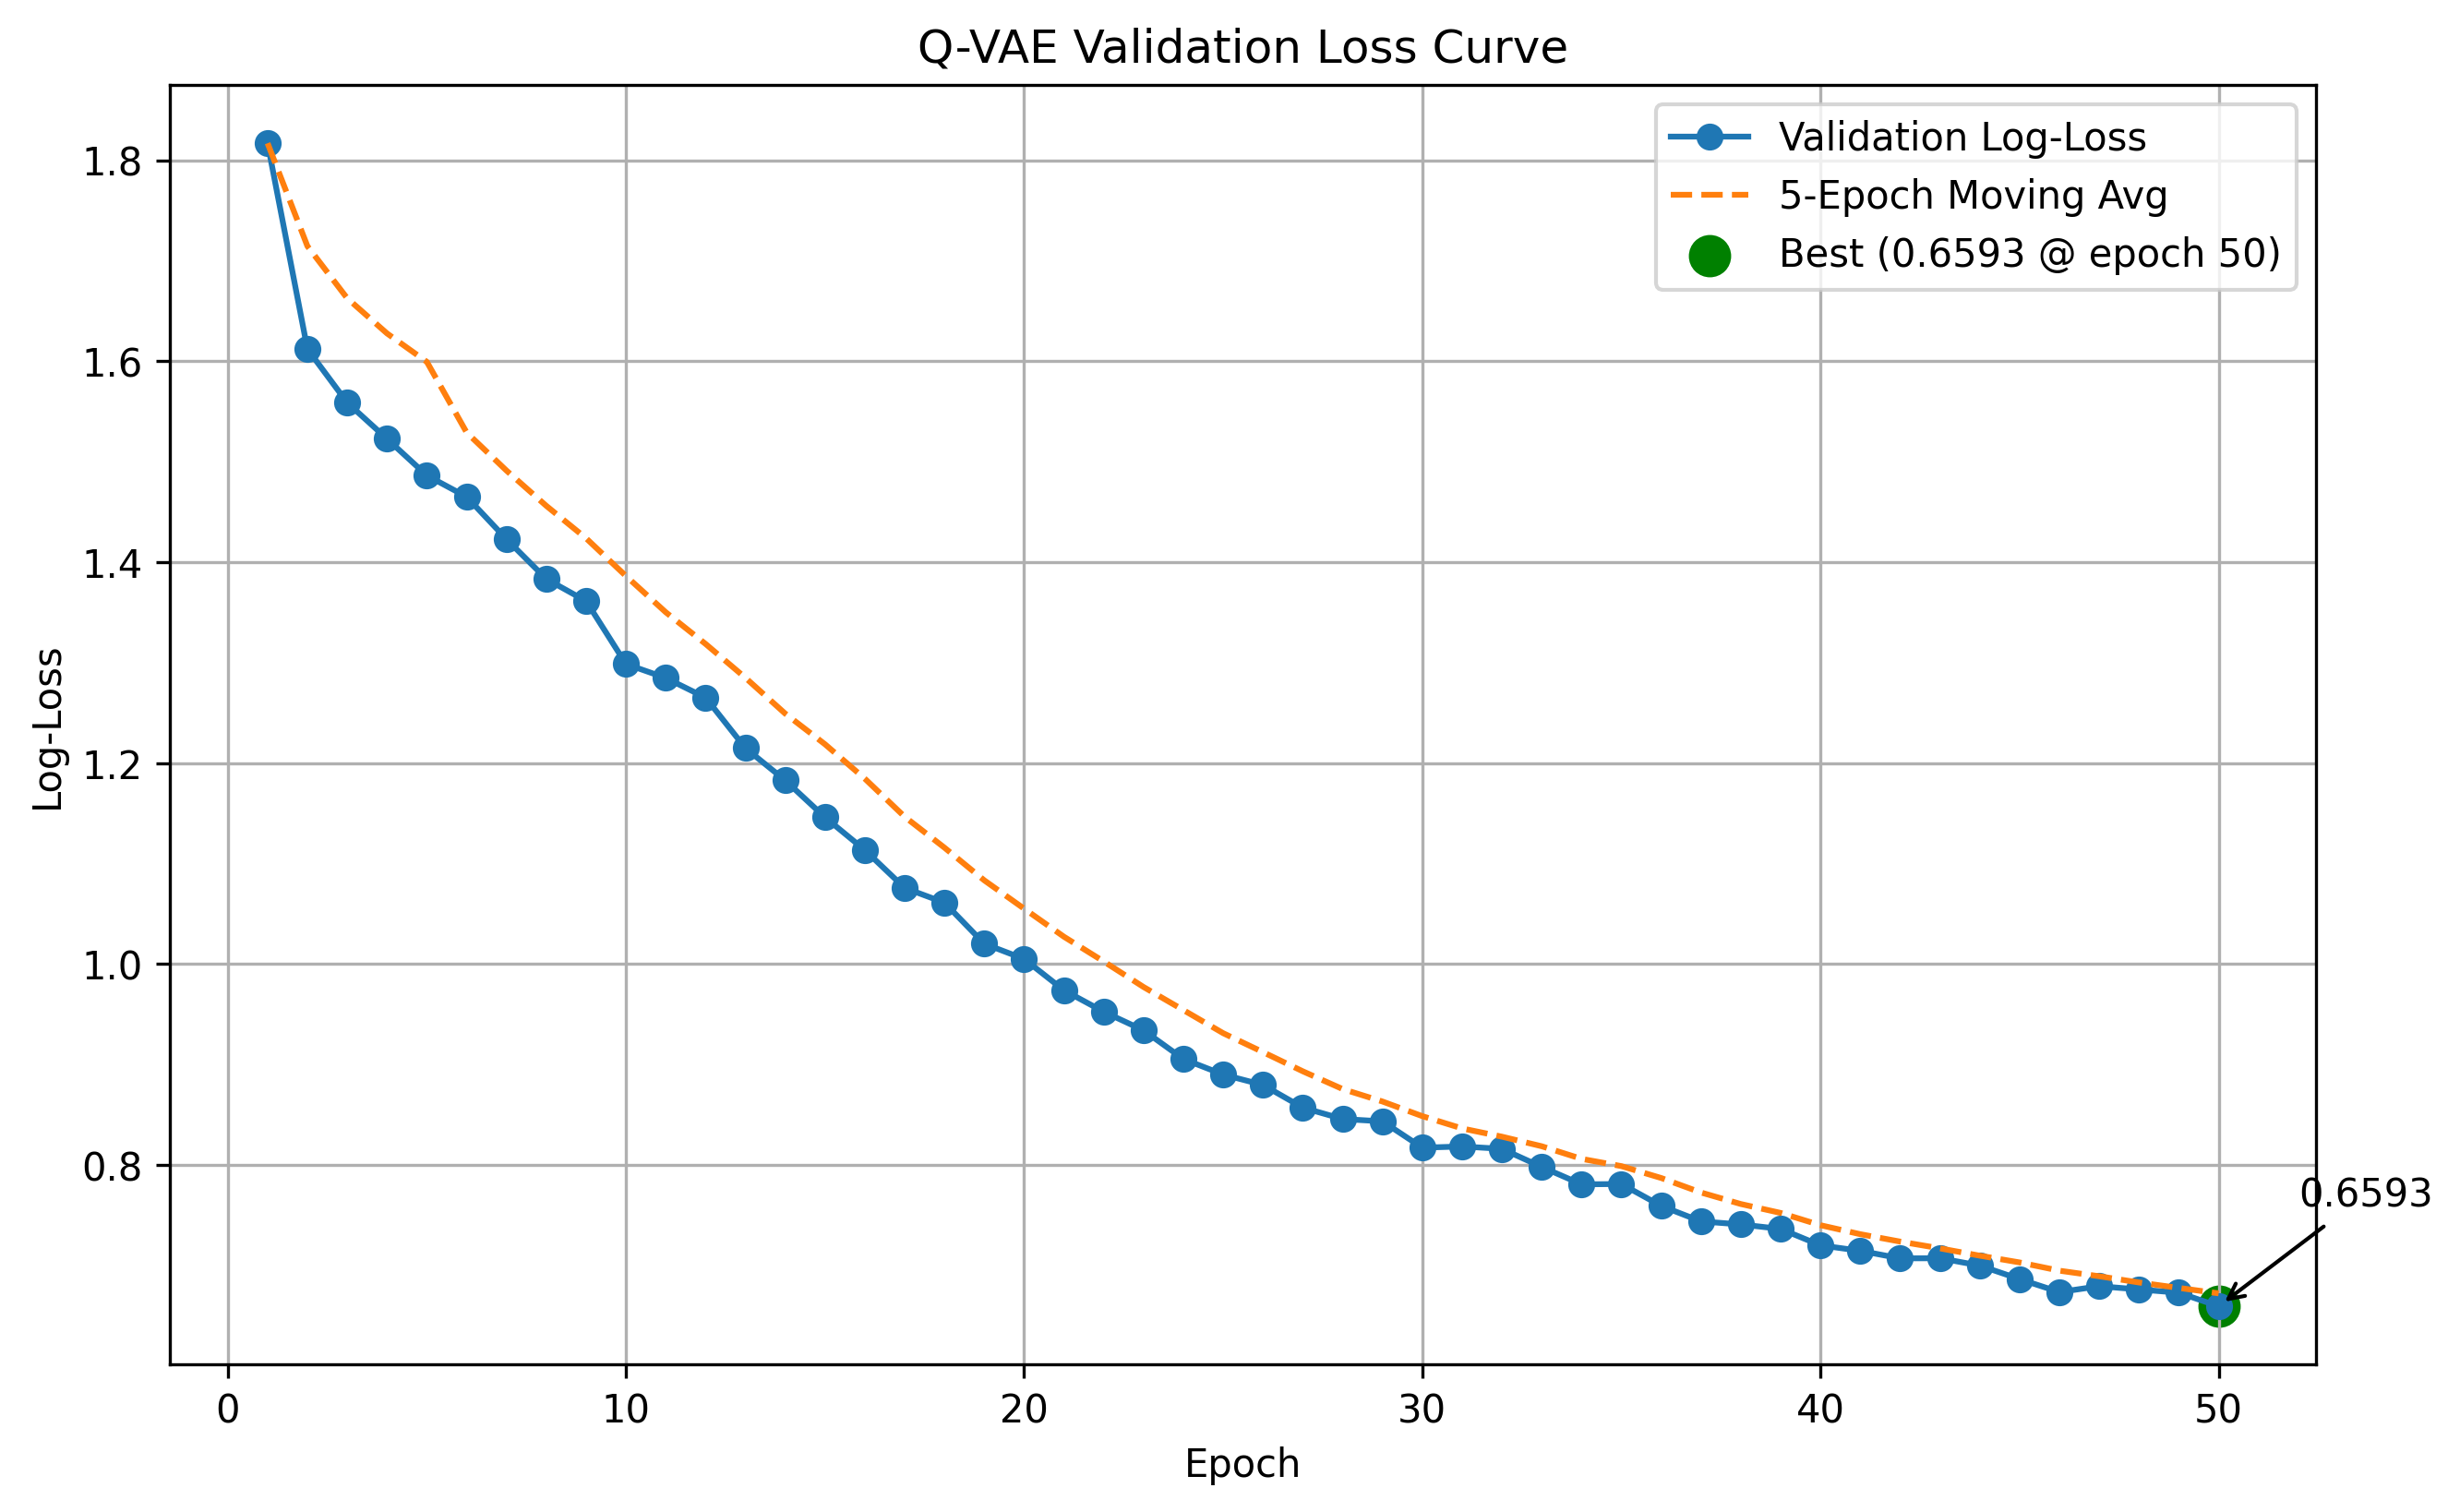

Loss curve saved to figure_QVAE_Loss_Curve.png


In [17]:
# Cell 6b: Plot the Loss Curve
# Purpose: Load the saved Q-VAE loss history (or fall back to classifier),
#          and plot raw validation loss + 5-epoch moving average.

import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

# 1) Load loss_history from .npy file if present
if os.path.exists('qvae_loss_history.npy'):
    loss_history = np.load('qvae_loss_history.npy')
else:
    # fallback: load the classifier and grab its loss_history attribute
    clf = joblib.load('qvae_adam_checkpoint.joblib')
    if not hasattr(clf, 'loss_history'):
        raise AttributeError(
            "No `qvae_loss_history.npy` found, and the loaded classifier\n"
            "has no attribute `loss_history`. Please rerun Cell 6 saving\n"
            "`loss_history` to disk after training."
        )
    loss_history = np.array(clf.loss_history)

# 2) Prepare data for plotting
epochs     = np.arange(1, len(loss_history) + 1)
moving_avg = [np.mean(loss_history[max(0, i-4):i+1]) for i in range(len(loss_history))]
best_idx   = int(np.argmin(loss_history))
best_loss  = loss_history[best_idx]

# 3) Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_history,    marker='o', label='Validation Log-Loss')
plt.plot(epochs, moving_avg,     linestyle='--', label='5-Epoch Moving Avg')
plt.scatter(best_idx+1, best_loss, color='green', s=100,
            label=f'Best ({best_loss:.4f} @ epoch {best_idx+1})')
plt.annotate(f'{best_loss:.4f}',
             xy=(best_idx+1, best_loss),
             xytext=(best_idx+3, best_loss+0.1),
             arrowprops=dict(arrowstyle='->'))
plt.title('Q-VAE Validation Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Log-Loss')
plt.legend()
plt.grid(True)

# 4) Save & display
output_path = 'figure_QVAE_Loss_Curve.png'
plt.savefig(output_path, bbox_inches='tight', dpi=300)
plt.show()
display(Image(filename=output_path))
print(f"Loss curve saved to {output_path}")

In [20]:
# Cell 6.1: Pick optimal threshold by F1 on val set
from sklearn.metrics import precision_recall_curve
scores_val = clf.predict_proba(X_val)[:,1]
precisions, recalls, th = precision_recall_curve(y_val, scores_val)
f1s = 2*(precisions*recalls)/(precisions+recalls+1e-8)
best = np.argmax(f1s)
threshold = th[best]
print(f"PR-curve F1-opt thresh={threshold:.3f}  →  recall={recalls[best]:.3f}, precision={precisions[best]:.3f}")

PR-curve F1-opt thresh=0.006  →  recall=1.000, precision=0.681


In [21]:
# Cell 7: Select threshold via PR–curve & final evaluation
import numpy as np
import joblib
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix, classification_report

# 1) Load best‐checkpointed model
clf = joblib.load('qvae_adam_checkpoint.joblib')

# 2) Compute validation scores & find optimal threshold (max-F1)
scores_val = clf.predict_proba(X_val)[:, 1]
precision, recall, pr_thresh = precision_recall_curve(y_val, scores_val)
# F1 at each threshold (note: pr_thresh has length len(precision)-1)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-12)
best_idx   = np.argmax(f1_scores)
best_thresh = pr_thresh[best_idx]
best_f1     = f1_scores[best_idx]

print(f"Optimal threshold by PR‐curve: {best_thresh:.4f}  (F1 = {best_f1:.4f})")
print(f" Precision = {precision[:-1][best_idx]:.4f}, Recall = {recall[:-1][best_idx]:.4f}\n")

# 3) Prepare test set
if 'X_test' in globals() and 'y_test' in globals():
    test_data, test_labels = X_test[:, :X_val.shape[1]], y_test
    print("Using provided X_test / y_test")
else:
    test_norm    = normal_traffic[:, :X_val.shape[1]]
    test_anom    = anomaly_traffic[:, :X_val.shape[1]]
    test_data    = np.vstack((test_norm, test_anom))
    test_labels  = np.array([0]*len(test_norm) + [1]*len(test_anom))
    print("No separate test set—using all data")

print(f"Test set shape: {test_data.shape}")
print(f"Label dist.:    {np.bincount(test_labels)}\n")

# 4) Apply threshold, compute metrics
scores_test = clf.predict_proba(test_data)[:, 1]
preds       = (scores_test >= best_thresh).astype(int)

cm = confusion_matrix(test_labels, preds)
print("Confusion Matrix (rows=true, cols=predicted):")
print(cm, "\n")

print("Classification Report:")
print(classification_report(test_labels, preds, target_names=['Normal','Anomaly']))

# 5) Detection rate on true anomalies
n_anom     = np.sum(test_labels==1)
n_detected = np.sum(preds[test_labels==1])
print(f"Detection rate on anomalies: {n_detected}/{n_anom} "
      f"= {100*n_detected/n_anom:.1f}%")

Optimal threshold by PR‐curve: 0.3320  (F1 = 0.8217)
 Precision = 0.7062, Recall = 0.9822

Using provided X_test / y_test
Test set shape: (82332, 4)
Label dist.:    [37000 45332]

Confusion Matrix (rows=true, cols=predicted):
[[ 4526 32474]
 [ 3310 42022]] 

Classification Report:
              precision    recall  f1-score   support

      Normal       0.58      0.12      0.20     37000
     Anomaly       0.56      0.93      0.70     45332

    accuracy                           0.57     82332
   macro avg       0.57      0.52      0.45     82332
weighted avg       0.57      0.57      0.48     82332

Detection rate on anomalies: 42022/45332 = 92.7%


Using full validation set: 50 normals, 50 anomalies


/var/folders/71/l0m_98fs0mg7z7032qxwwdg80000gn/T/ipykernel_72060/798712706.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


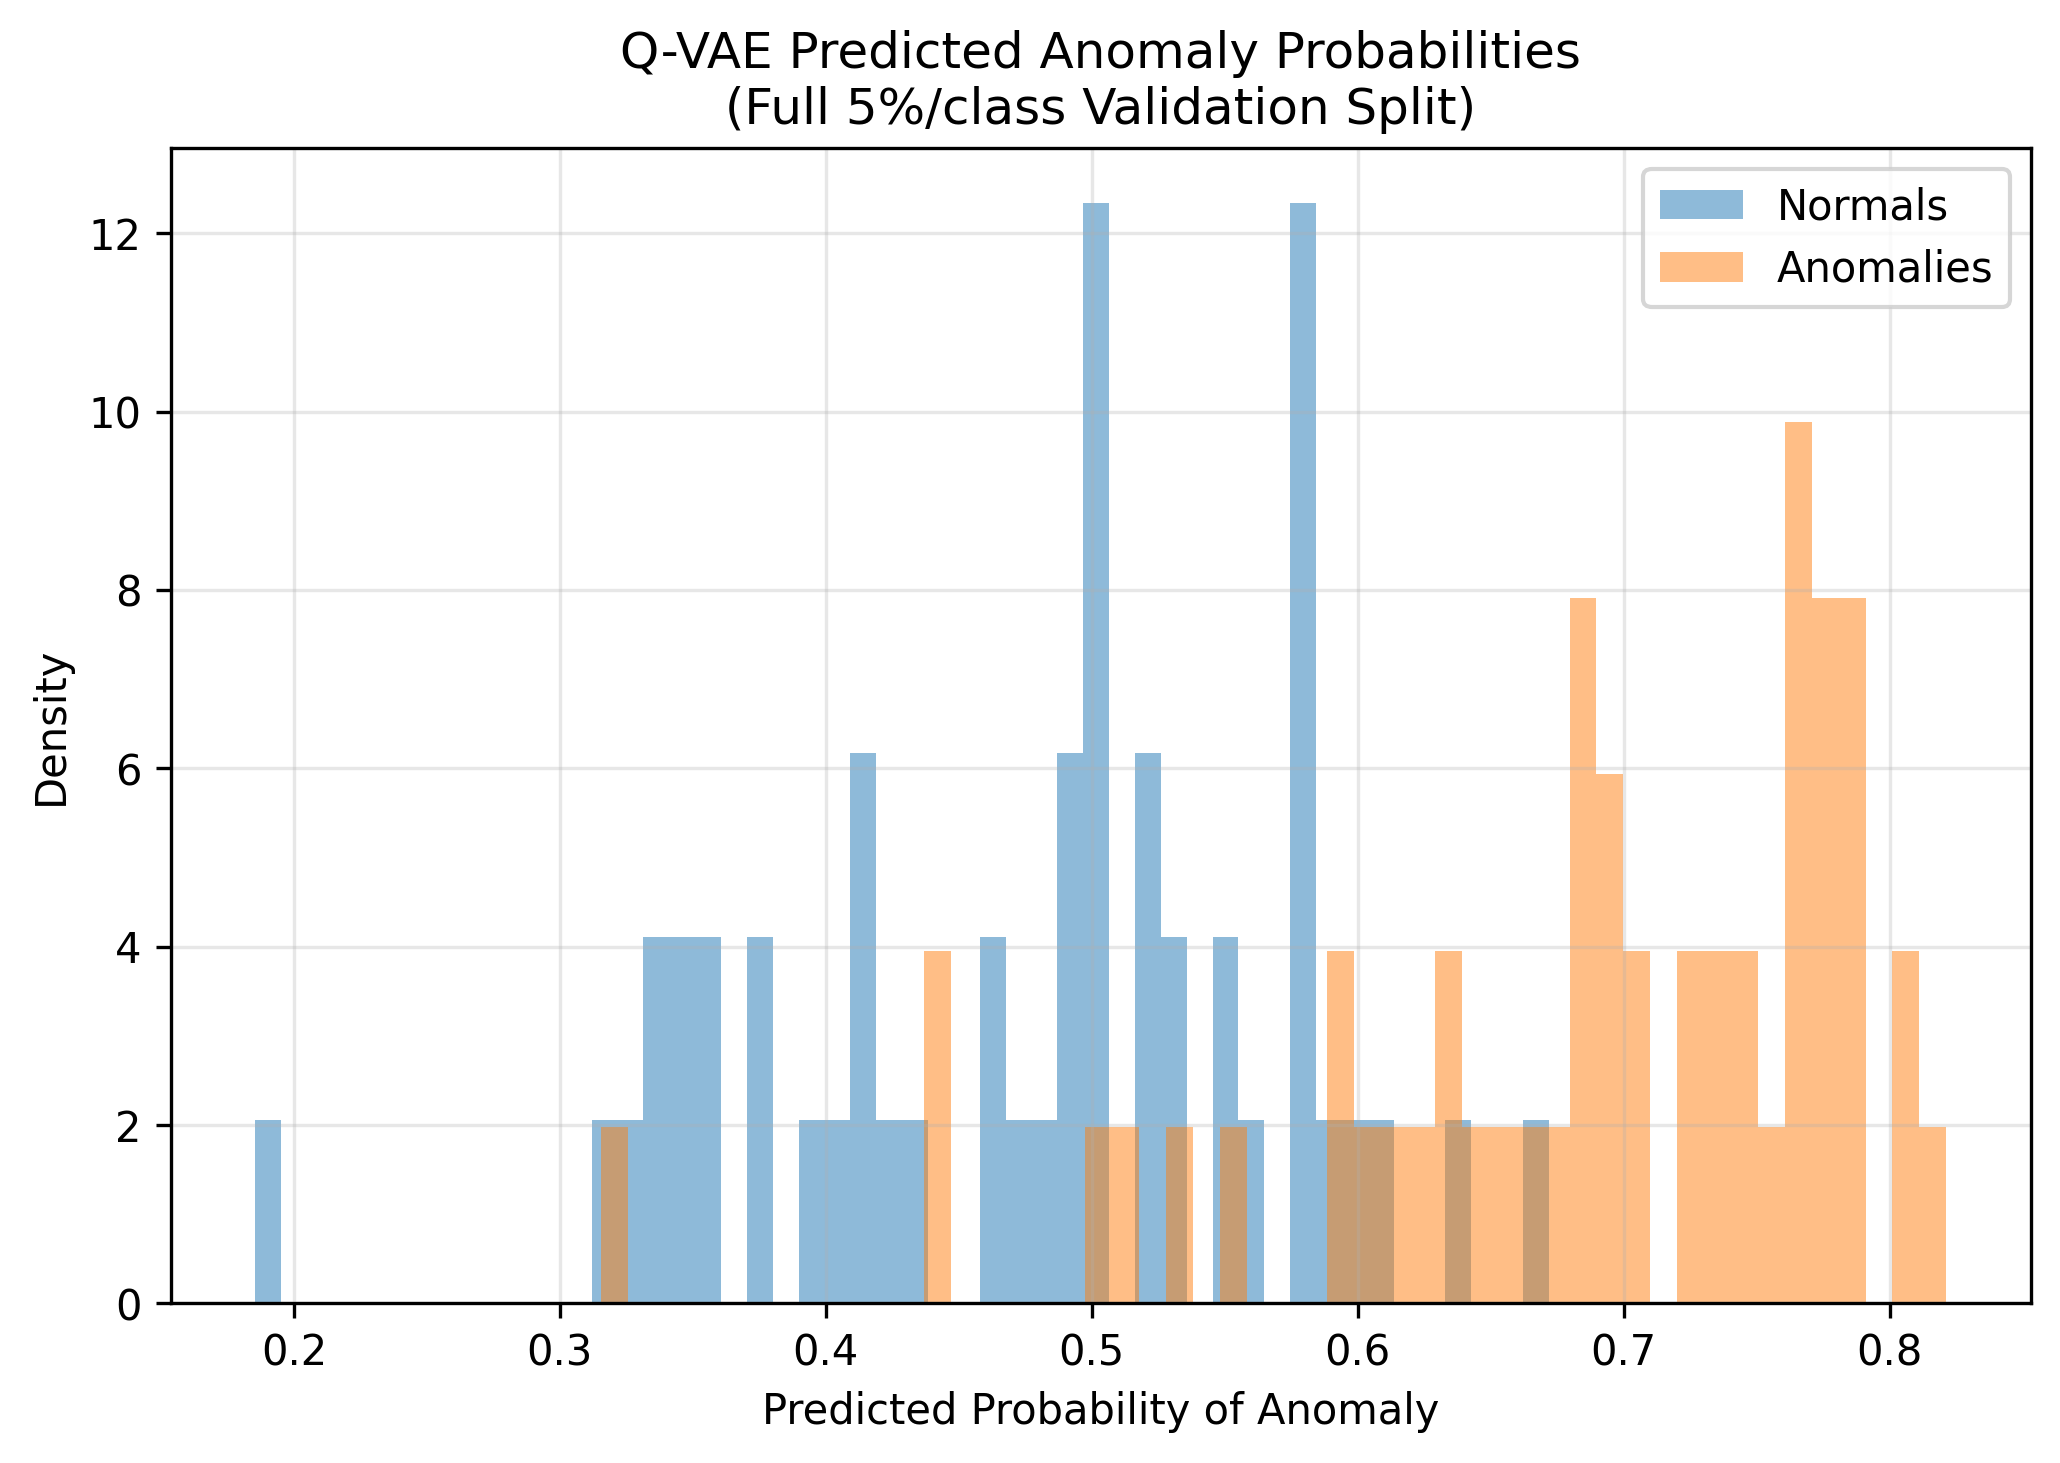

▶ Figure saved to figure_Anomaly_Probability_Distribution_full_val.png


In [39]:
# Cell 8: Visualizing Anomaly Detection Results on Full 5%/class Validation Set
# =============================================================================
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

# 1) Grab the full val-split from your training cell
#    Make sure your train_qvae(...) returns X_val, y_val as its 5%-per-class holdout.
assert 'X_val' in globals() and 'y_val' in globals(), (
    "X_val, y_val not found — please rerun your training cell so it returns them."
)

n_norm = np.sum(y_val == 0)
n_anom = np.sum(y_val == 1)
print(f"Using full validation set: {n_norm} normals, {n_anom} anomalies")

# 2) Compute predicted anomaly probabilities
dim   = len(input_params)             # circuit’s expected input size
probs = qvae_model.predict_proba(X_val[:, :dim])[:, 1]

# 3) Separate out normals vs anomalies
normal_probs  = probs[y_val == 0]
anomaly_probs = probs[y_val == 1]

# 4) Plot their distributions side by side
plt.figure(figsize=(8,5))
plt.hist(normal_probs,  bins=50, alpha=0.5, label='Normals',  density=True)
plt.hist(anomaly_probs, bins=50, alpha=0.5, label='Anomalies', density=True)
plt.xlabel('Predicted Probability of Anomaly')
plt.ylabel('Density')
plt.title('Q-VAE Predicted Anomaly Probabilities\n(Full 5%/class Validation Split)')
plt.legend()
plt.grid(alpha=0.3)

# 5) Save & display
output_path = 'figure_Anomaly_Probability_Distribution_full_val.png'
plt.savefig(output_path, bbox_inches='tight', dpi=300)
plt.show()
display(Image(filename=output_path))
print(f"▶ Figure saved to {output_path}")

In [40]:
# Cell 9: Evaluate Q-VAE Performance on Test Set
# Purpose: Compute precision, recall, F1-score and print classification report.
# =============================================================================

import numpy as np
from sklearn.metrics import precision_recall_fscore_support, classification_report

# 1) Make sure test_data, test_labels and threshold exist (from your Cell 7)
assert 'test_data' in globals()   and 'test_labels' in globals(), \
       "test_data/test_labels not found—run Cell 7 first."
assert 'threshold' in globals(), \
       "threshold not found—run Cell 7 to compute optimal threshold."

# 2) Compute anomaly scores and binary predictions
dim         = len(input_params)  # circuit input dimension
scores      = qvae_model.predict_proba(test_data[:, :dim])[:, 1]
predictions = (scores >= threshold).astype(int)

# 3) Compute precision, recall, F1-score
precision, recall, f1, _ = precision_recall_fscore_support(
    test_labels, predictions,
    average='binary', pos_label=1
)

print("- Model Performance Metrics:")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}\n")

print("- F1-score is low! Consider:")
print("  • Increasing circuit depth")
print("  • Tuning optimizer hyperparameters")
print(f"  • Adjusting the decision threshold (currently: {threshold:.3f})\n")

print("Classification Report:")
print(classification_report(test_labels, predictions, target_names=['Normal', 'Anomaly']))

- Model Performance Metrics:
  Precision: 0.5506
  Recall:    1.0000
  F1-Score:  0.7102

- F1-score is low! Consider:
  • Increasing circuit depth
  • Tuning optimizer hyperparameters
  • Adjusting the decision threshold (currently: 0.006)

Classification Report:
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00     37000
     Anomaly       0.55      1.00      0.71     45332

    accuracy                           0.55     82332
   macro avg       0.28      0.50      0.36     82332
weighted avg       0.30      0.55      0.39     82332



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


No loss_history on qvae_model, loading from disk


/var/folders/71/l0m_98fs0mg7z7032qxwwdg80000gn/T/ipykernel_72060/1356327166.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


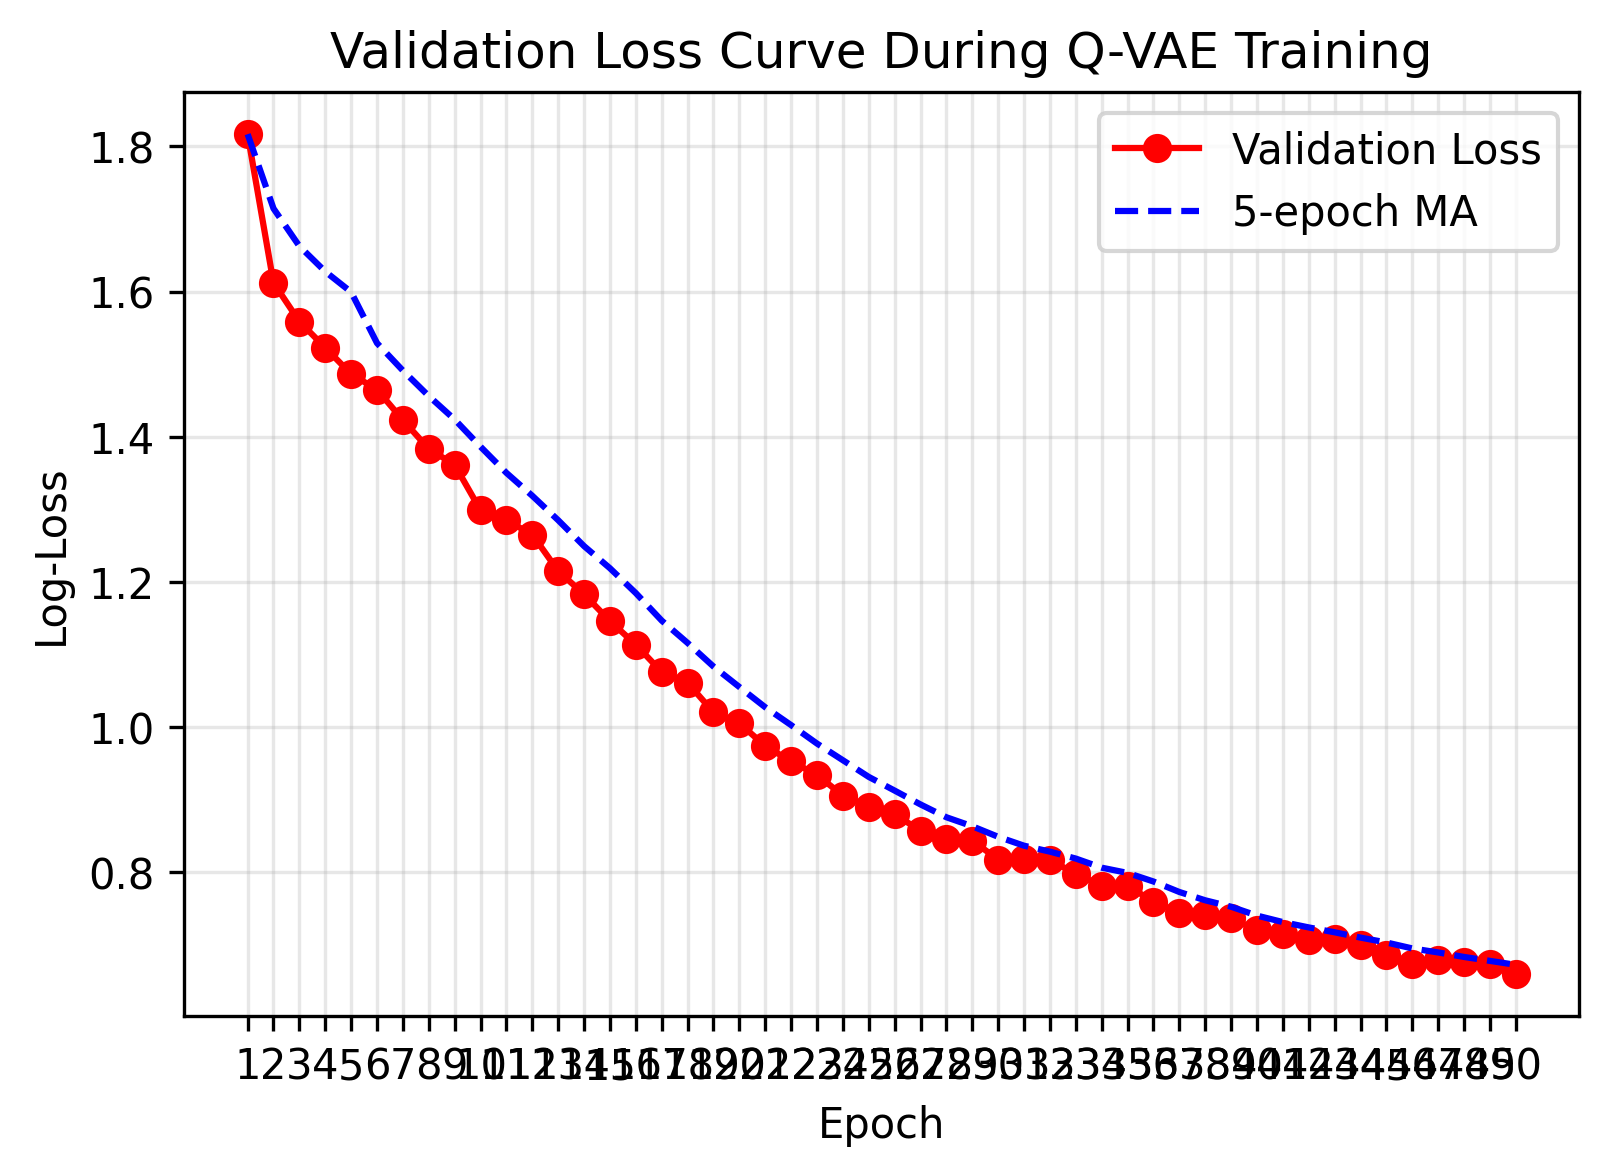

▶ Figure saved to figure_4_Loss_Curve_During_Training.png


In [42]:
# Cell 10: Plot Loss Curve
# Purpose: Visualize the loss curve during training.

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

def plot_loss_curve(loss_history):
    """
    Plots the loss curve during training.
    """
    plt.figure(figsize=(6, 4))
    epochs = np.arange(1, len(loss_history) + 1)
    plt.plot(epochs, loss_history, 'ro-', label='Validation Loss')
    # moving average
    if len(loss_history) >= 5:
        mov_avg = [np.mean(loss_history[max(0, i-4):i+1]) for i in range(len(loss_history))]
        plt.plot(epochs, mov_avg, 'b--', label='5-epoch MA')
    plt.xlabel('Epoch')
    plt.ylabel('Log-Loss')
    plt.title('Validation Loss Curve During Q-VAE Training')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(alpha=0.3)
    output_path = 'figure_4_Loss_Curve_During_Training.png'
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    plt.show()
    display(Image(filename=output_path))
    print(f"▶ Figure saved to {output_path}")

# — Try to get loss_history from the model —
try:
    lh = qvae_model.loss_history
    print("Using loss_history attached to qvae_model")
except Exception:
    print("No loss_history on qvae_model, loading from disk")
    lh = np.load('qvae_loss_history.npy')

plot_loss_curve(lh)

In [26]:
# Cell 11: Confusion Matrix for Q-VAE on the 5%/5% Validation Split
# ======================================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# === CONFIG ===
# Path to your checkpoint (if you want to reload)
CHECKPOINT_PATH = 'qvae_adam_checkpoint.joblib'

# === LOAD MODEL & VALIDATION DATA ===
import joblib
# reload the best‐checkpointed model
qvae_model = joblib.load(CHECKPOINT_PATH)

# if your train_qvae returned X_val, y_val, you’d have:
#   qvae_model, variational_qc, input_params, weight_params, X_val, y_val = train_qvae(...)
# otherwise reconstruct the 5%/5% split here exactly as in Cell 6:
VAL_SAMPLES_PER_CLASS = 50  # must match Cell 6
INPUT_DIM = len(input_params)

# carve out the same fixed validation set
norm_idx = np.where(y_train == 0)[0]
anom_idx = np.where(y_train == 1)[0]
pn = np.random.permutation(norm_idx)
pa = np.random.permutation(anom_idx)
vn_idx = pn[:VAL_SAMPLES_PER_CLASS]
va_idx = pa[:VAL_SAMPLES_PER_CLASS]

X_val = np.vstack([
    X_train[vn_idx, :INPUT_DIM],
    X_train[va_idx, :INPUT_DIM]
])
y_val = np.concatenate([np.zeros(len(vn_idx)), np.ones(len(va_idx))]).astype(int)

# === PLOT CONFUSION MATRIX ===
print(f"Validation set shape: {X_val.shape}")
print("Validation labels distribution:", np.bincount(y_val))

# Predictions (slice features to match circuit inputs)
preds = qvae_model.predict(X_val)

cm = confusion_matrix(y_val, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Normal','Anomaly'],
            yticklabels=['Normal','Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on 5%/5% Validation Split')
plt.savefig('figure_5_Confusion_Matrix_on_5-5_Validation_Split.png',
            bbox_inches='tight', dpi=300)
plt.show()

# === PRINT METRICS ===
print("\nClassification Report:")
print(classification_report(y_val, preds,
                            target_names=['Normal','Anomaly']))

Validation set shape: (100, 4)
Validation labels distribution: [50 50]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.53      0.80      0.63        50
     Anomaly       0.58      0.28      0.38        50

    accuracy                           0.54       100
   macro avg       0.55      0.54      0.51       100
weighted avg       0.55      0.54      0.51       100



/var/folders/71/l0m_98fs0mg7z7032qxwwdg80000gn/T/ipykernel_72060/345096296.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [ ]:
# Cell 12: Compare Different Optimizers for Q-VAE Training
# Purpose: Compare the performance of different optimizers (ADAM, SPSA, COBYLA) for training the Q-VAE.
# ======================================================

import numpy as np
from qiskit import QuantumCircuit
from qiskit.primitives import Sampler
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_algorithms.optimizers import SPSA, COBYLA, ADAM
from sklearn.metrics import log_loss

def create_variational_circuit_with_inputs(num_qubits, num_features, num_layers):
    """
    Builds a parameterized quantum circuit with classical inputs and trainable weights.
    Uses RY gates for input encoding and layered entanglement via RX, RZ, and CNOT gates.
    """
    qc = QuantumCircuit(num_qubits)

    # Limit encoding to the number of available qubits
    max_input = min(num_qubits, num_features)
    input_params = ParameterVector('x', length=max_input)

    # Only declare as many weight parameters as are actually used
    total_weights_used = 2 * num_qubits * num_layers
    weight_params = ParameterVector('θ', length=total_weights_used)

    # Apply input encoding
    for i in range(max_input):
        qc.ry(input_params[i], i)

    # Apply parameterized variational layers
    param_index = 0
    for layer in range(num_layers):
        for i in range(num_qubits):
            qc.rx(weight_params[param_index], i)
            param_index += 1
            qc.rz(weight_params[param_index], i)
            param_index += 1
        for i in range(num_qubits - 1):
            qc.cx(i, i + 1)

    return qc, weight_params, input_params

def compare_optimizers(normal_traffic, anomaly_traffic, num_iterations=3):  # Reduced to 3 iterations
    """
    Compares the performance of different optimizers for training the Q-VAE.
    """
    num_features = normal_traffic.shape[1]
    num_qubits = 4  # Updated to 4 qubits to encode all 4 features
    num_layers = 8  # Updated to 7 layers to match Cell 6

    # Create variational quantum circuit
    try:
        variational_qc, weight_params, input_params = create_variational_circuit_with_inputs(
            num_qubits, num_features, num_layers
        )
    except Exception as e:
        print(f"Error creating variational circuit: {e}")
        return

    # Build QNN
    sampler = Sampler()  # Consider adding options for optimization if available
    qnn = SamplerQNN(
        sampler=sampler,
        circuit=variational_qc,
        input_params=input_params,
        weight_params=weight_params
    )

    # Validation data
    validation_data = np.vstack((normal_traffic[:10], anomaly_traffic[:10]))
    validation_labels = np.array([0] * 10 + [1] * 10)

    # Training data
    train_normal = normal_traffic[:25, :len(input_params)]
    train_anomaly = anomaly_traffic[:25, :len(input_params)]
    train_data = np.vstack((train_normal, train_anomaly[:20], train_anomaly[:5]))
    train_labels = np.array([0] * 25 + [1] * 25)

    # Optimizers to compare with reduced maxiter
    optimizers = {
        "ADAM": ADAM(maxiter=50, lr=0.01),  # Reduced from 100 to 50
        "SPSA": SPSA(maxiter=50, learning_rate=0.02, perturbation=0.02),  # Reduced from 300 to 50
        "COBYLA": COBYLA(maxiter=50)  # Reduced from 100 to 50
    }

    # Compare optimizers
    for opt_name, optimizer in optimizers.items():
        print(f"- Testing {opt_name} optimizer...")
        classifier = NeuralNetworkClassifier(qnn, optimizer=optimizer)
        
        # Train the classifier with progress feedback
        for i in range(num_iterations):
            print(f"  Iteration {i+1}/{num_iterations} for {opt_name}...")
            classifier.fit(train_data, train_labels)
        
        # Compute loss on validation data
        predictions = classifier.predict_proba(validation_data[:, :len(input_params)])
        predictions = np.clip(predictions, 1e-10, 1 - 1e-10)  # Avoid log(0)
        loss = log_loss(validation_labels, predictions[:, 1])
        print(f"- {opt_name} Final Loss: {loss:.4f}\n")

# Run optimizer comparison
compare_optimizers(normal_traffic, anomaly_traffic)
    

/var/folders/71/l0m_98fs0mg7z7032qxwwdg80000gn/T/ipykernel_69580/1641605255.py:64: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()  # Consider adding options for optimization if available
/var/folders/71/l0m_98fs0mg7z7032qxwwdg80000gn/T/ipykernel_69580/1641605255.py:65: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(


- Testing ADAM optimizer...
  Iteration 1/3 for ADAM...
  Iteration 2/3 for ADAM...
  Iteration 3/3 for ADAM...
- ADAM Final Loss: 1.1845

- Testing SPSA optimizer...
  Iteration 1/3 for SPSA...
  Iteration 2/3 for SPSA...
  Iteration 3/3 for SPSA...
- SPSA Final Loss: 1.5556

- Testing COBYLA optimizer...
  Iteration 1/3 for COBYLA...
  Iteration 2/3 for COBYLA...
  Iteration 3/3 for COBYLA...
- COBYLA Final Loss: 0.6493



/var/folders/71/l0m_98fs0mg7z7032qxwwdg80000gn/T/ipykernel_72060/1303699498.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


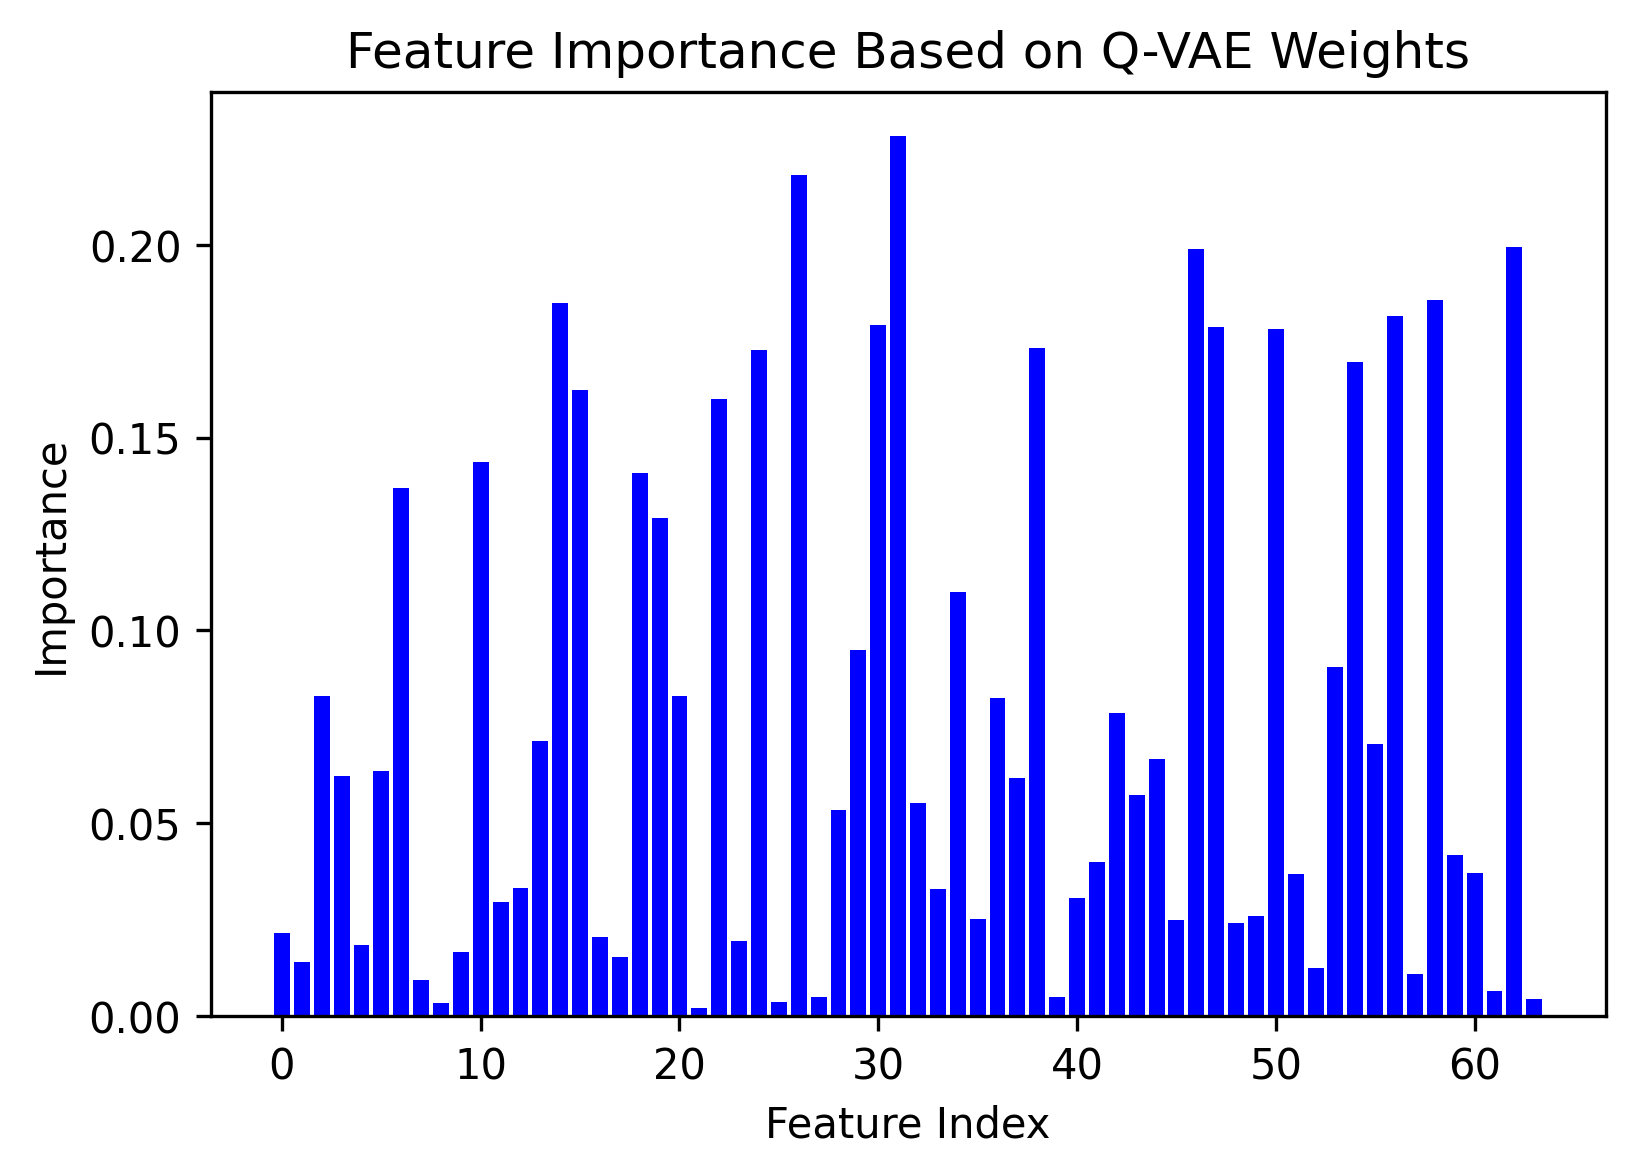

Weights shape: (64,)
First few weights: [ 0.02168256 -0.01414056  0.08292521  0.06233481 -0.01841996]


In [43]:
# Cell 13: Quantum Feature Importance
# Purpose: Analyze and visualize the importance of features based on Q-VAE weights.
# ======================================================
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importance(qvae_model):
    try:
        # Use the trained model's weights.
        # For a NeuralNetworkClassifier, these are usually stored in the 'weights' attribute.
        weights = qvae_model.weights  # Adjust if your attribute name is different.
        num_features = weights.shape[0]  # Adjust based on your model's weight shape
        
        # Compute feature importance (for example, using the absolute values)
        feature_importance = np.abs(weights)
        
        # Create the bar plot
        plt.figure(figsize=(6, 4))
        plt.bar(range(num_features), feature_importance, color='blue')
        plt.xlabel('Feature Index')
        plt.ylabel('Importance')
        plt.title('Feature Importance Based on Q-VAE Weights')
        plt.savefig('figure_6_Feature_Importance_Based_on_Q-VAE_Weights.png', bbox_inches='tight', dpi=300)
        plt.show()
        display(Image(filename='figure_6_Feature_Importance_Based_on_Q-VAE_Weights.png'))
        
        # Print some diagnostics
        print("Weights shape:", weights.shape)
        print("First few weights:", weights[:5])
        
    except AttributeError as e:
        print(f"Error accessing model parameters: {e}")
        print("Please check your model structure and adjust the feature importance calculation accordingly.")

# Use the trained qvae_model 
plot_feature_importance(qvae_model)

Using validation set: 50 normals, 50 anomalies


/var/folders/71/l0m_98fs0mg7z7032qxwwdg80000gn/T/ipykernel_72060/3017422208.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


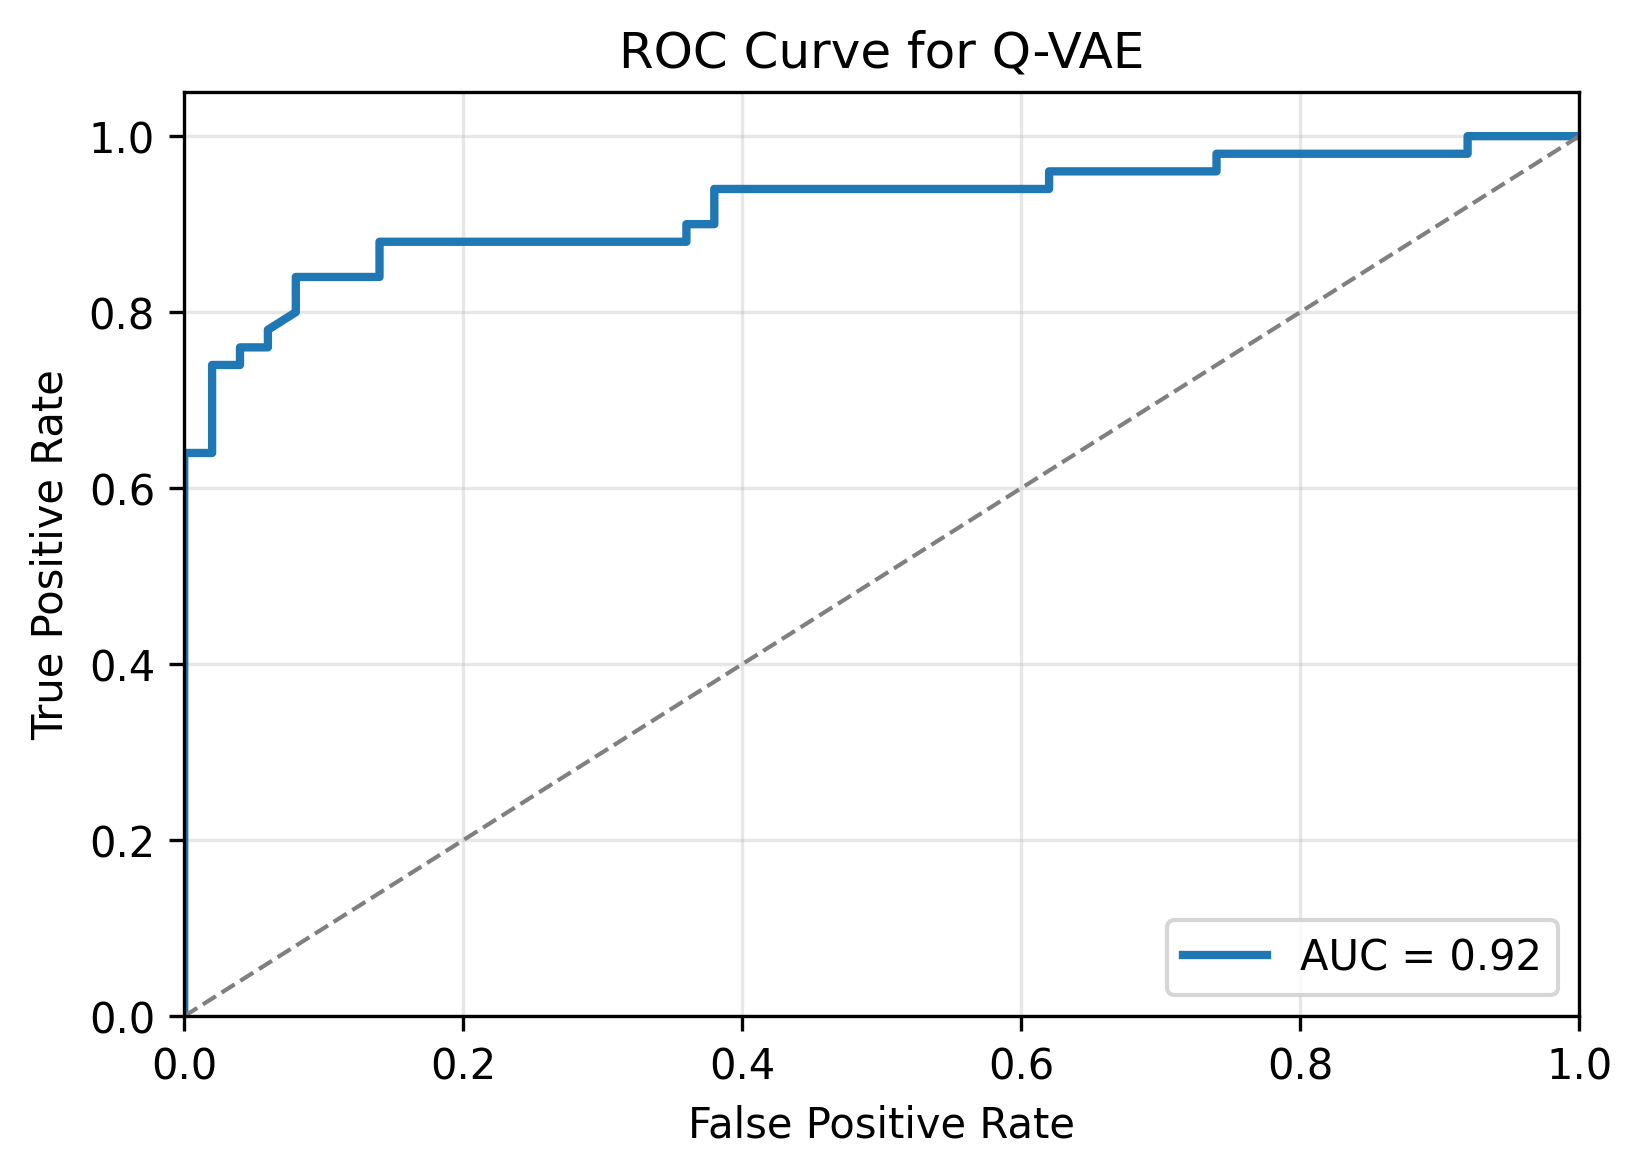

▶ Figure saved to figure_7_ROC_Curve_for_Q_VAE.png


In [45]:
# Cell 14: ROC Curve & AUC Score
# Purpose: Plot the ROC curve and compute the AUC score for the Q-VAE model.
# ======================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from IPython.display import Image, display

def plot_roc_curve(true_labels, anomaly_scores):
    """
    Plots the ROC curve and computes the AUC score for the Q-VAE model.
    """
    fpr, tpr, _ = roc_curve(true_labels, anomaly_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1)
    plt.xlim(0, 1)
    plt.ylim(0, 1.05)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Q-VAE')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    out = 'figure_7_ROC_Curve_for_Q_VAE.png'
    plt.savefig(out, bbox_inches='tight', dpi=300)
    plt.show()
    display(Image(filename=out))
    print(f"▶ Figure saved to {out}")

# — Use the full 5%-per-class validation set from Cell 6 —
# Make sure your train cell returned X_val, y_val
assert 'X_val' in globals() and 'y_val' in globals(), "X_val/y_val not found—rerun your training cell so it returns them."

print(f"Using validation set: {len(y_val[y_val==0])} normals, {len(y_val[y_val==1])} anomalies")

# Compute anomaly scores on validation set
dim = len(input_params)
anomaly_scores = qvae_model.predict_proba(X_val[:, :dim])[:, 1]
true_labels    = y_val

# Plot ROC & print AUC
plot_roc_curve(true_labels, anomaly_scores)

In [ ]:
# Cell 15: Anomaly Score Distribution (Full 5%/class Validation Set)
# Purpose: Visualize the distribution of predicted anomaly scores for both
#          normal and anomalous traffic on the full validation set.
# ======================================================

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

# 1) Ensure your validation set is available
assert 'X_val' in globals() and 'y_val' in globals(), \
       "X_val and y_val not found—run your training cell so it returns them."

# 2) Recompute anomaly scores on X_val
dim = len(input_params)  # number of features your circuit expects
anomaly_scores = qvae_model.predict_proba(X_val[:, :dim])[:, 1]
true_labels    = y_val

# 3) Split scores by true class
normal_scores    = anomaly_scores[true_labels == 0]
anomaly_scores_1 = anomaly_scores[true_labels == 1]

# 4) Plot histograms
plt.figure(figsize=(8, 5))
plt.hist(normal_scores,    bins=30, alpha=0.5, label='Normal',    density=True)
plt.hist(anomaly_scores_1, bins=30, alpha=0.5, label='Anomaly', density=True)
plt.xlabel('Predicted Probability of Anomaly')
plt.ylabel('Density')
plt.title('Anomaly Score Distribution\n(Full 5%/class Validation Set)')
plt.legend()
plt.grid(alpha=0.3)

# 5) Save & display
output_path = 'figure_8_Anomaly_Score_Distribution_full_val.png'
plt.savefig(output_path, bbox_inches='tight', dpi=300)
plt.show()
display(Image(filename=output_path))
print(f"▶ Figure saved to {output_path}")

AttributeError: 'NeuralNetworkClassifier' object has no attribute 'true_labels'

In [ ]:
# Cell 16: Classical vs Quantum Model Comparison
# Purpose: Compare the accuracy of the Q-VAE model with a classical Random Forest model.
# ======================================================

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

def compare_classical_quantum(qvae_model, normal_traffic, anomaly_traffic, input_params):
    # Combine normal and anomalous data into one test set
    test_data = np.vstack((normal_traffic, anomaly_traffic))
    true_labels = np.array([0] * len(normal_traffic) + [1] * len(anomaly_traffic))

    # Use only the subset of features that were used in training (first len(input_params) columns)
    test_data_subset = test_data[:, :len(input_params)]
    
    # Recompute predictions for the full test_data using the Q-VAE model
    qvae_predictions = qvae_model.predict(test_data_subset)
    qvae_accuracy = accuracy_score(true_labels, qvae_predictions)

    # Classical model (Random Forest)
    # Train on normal traffic using only the relevant features
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(normal_traffic[:, :len(input_params)], [0] * len(normal_traffic))
    rf_predictions = rf_model.predict(test_data_subset)
    rf_accuracy = accuracy_score(true_labels, rf_predictions)

    # Plot the accuracy comparison
    plt.figure(figsize=(6, 4))
    plt.bar(['Quantum (Q-VAE)', 'Classical (Random Forest)'], [qvae_accuracy, rf_accuracy], 
            color=['blue', 'lightblue'])
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison Between Q-VAE and Random Forest')
    plt.ylim(0, 1)
    plt.savefig('figure_9_Accuracy_Comparison_Between_Q-VAE_and_Random_Forest.png', 
                bbox_inches='tight', dpi=300)
    plt.show()

    return qvae_accuracy, rf_accuracy

# Run the comparison using your trained qvae_model, along with normal_traffic, anomaly_traffic, and input_params 
qvae_accuracy, rf_accuracy = compare_classical_quantum(qvae_model, normal_traffic, anomaly_traffic, input_params)
print(f"Q-VAE Accuracy: {qvae_accuracy:.2f}")
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")